# Let's import a bunch of stuff

In [1]:
import sys
import seaborn as sb
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import argparse
import gc

%matplotlib inline

In [2]:
adata = sc.read("CLUESImmvarMono.V5.h5ad", cache=True)
adata.shape

(222532, 1419)

# Let's first cluster with slightly lower resolution

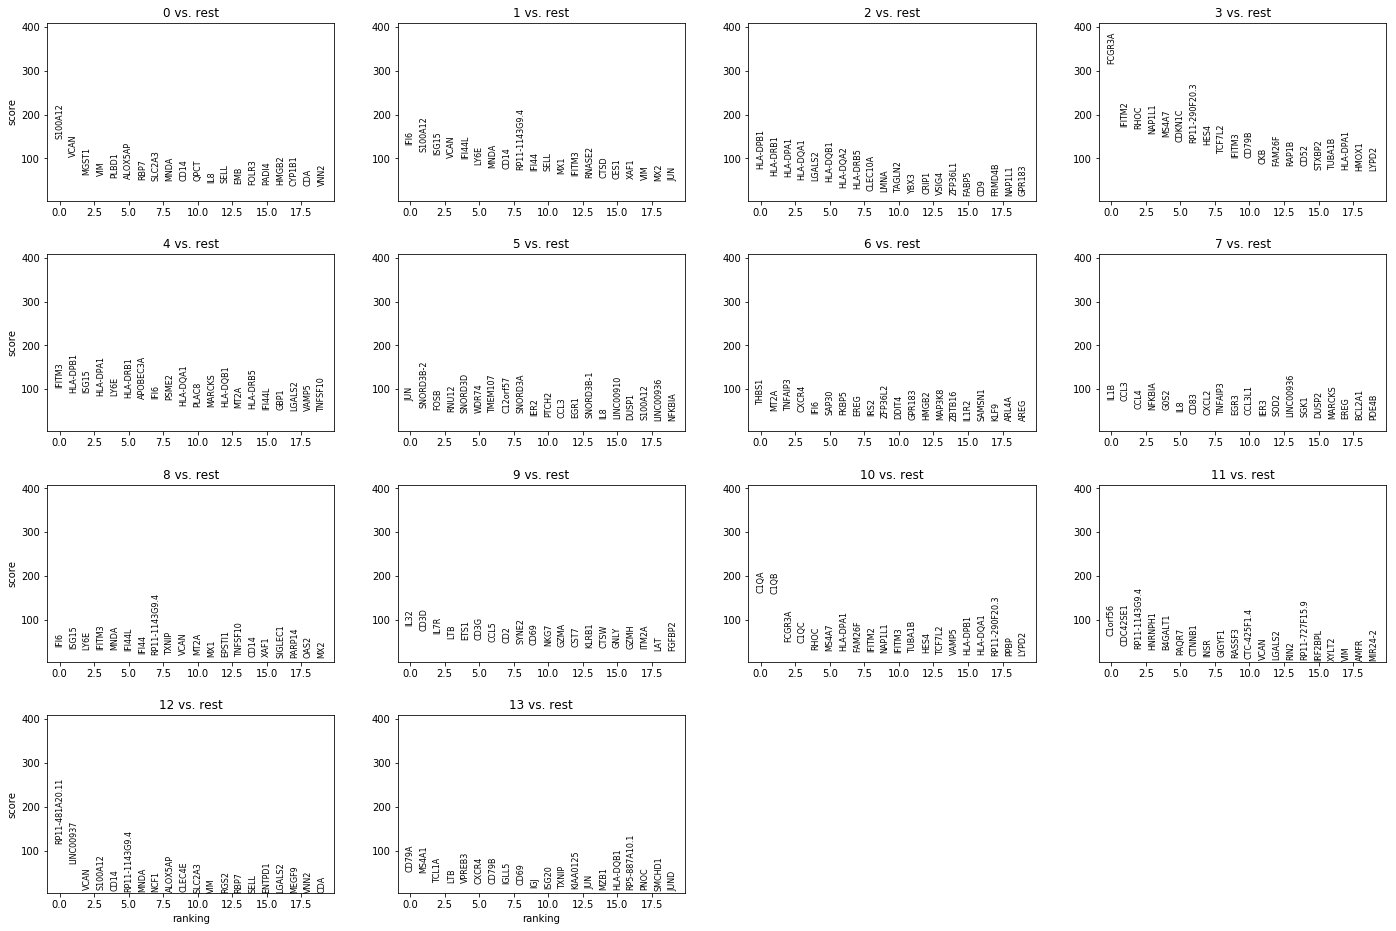

In [3]:
sc.tl.rank_genes_groups(adata, n_genes=20, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(adata)

## Also plot some differentially expressed genes

## And of course UMAP with the louvain clusters highlighted

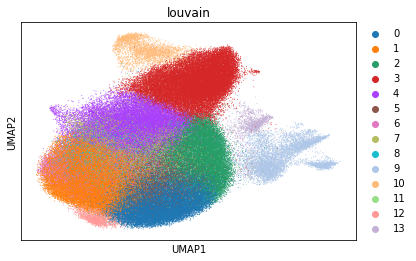

In [4]:
adata.uns['louvain_colors'] = sc.pl.palettes.vega_20_scanpy;
sc.pl.umap(adata, color='louvain', size=3)

In [120]:
## filter for the contaminating T and B cell
adata = adata[adata.obs.louvain != "13"];
adata = adata[adata.obs.louvain != "9"];
adata.shape

(213527, 1419)

In [123]:
sc.pp.pca(adata)

In [130]:
adata.obsm.__delitem__("X_diffmap")

In [131]:
sc.pp.neighbors(adata)


In [133]:
sc.tl.louvain(adata)

In [144]:
sc.tl.leiden(adata)

In [135]:
sc.tl.umap(adata)

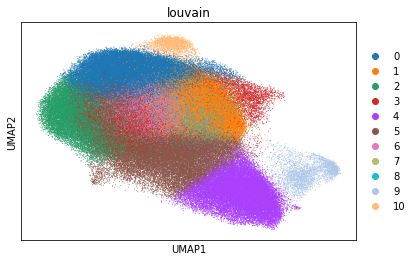

In [136]:
adata.uns['louvain_colors'] = sc.pl.palettes.vega_20_scanpy;
sc.pl.umap(adata, color='louvain', size=3)

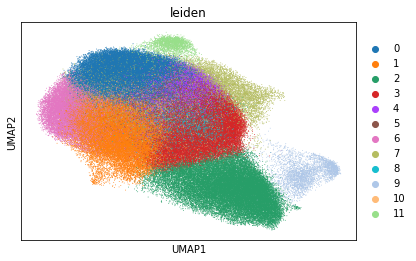

In [145]:
adata.uns['leiden_colors'] = sc.pl.palettes.vega_20_scanpy;
sc.pl.umap(adata, color='leiden', size=3)

In [97]:
# #plot UMAP of cell types colored by clusters
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='louvain', size=3)

In [98]:
# adata2 = sc.read("/Users/yechun/Downloads/CLUESImmVar_processed.V3.h5ad")
# for i in range(0,13) :
#     print(i,end=":")
#     print(len(adata.obs.index[adata.obs.louvain==str(i)]& adata2.obs.index)/len(adata.obs.index[adata.obs.louvain==str(i)]))

In [99]:
# sc.pp.regress_out(adata, ['batch_cov'])

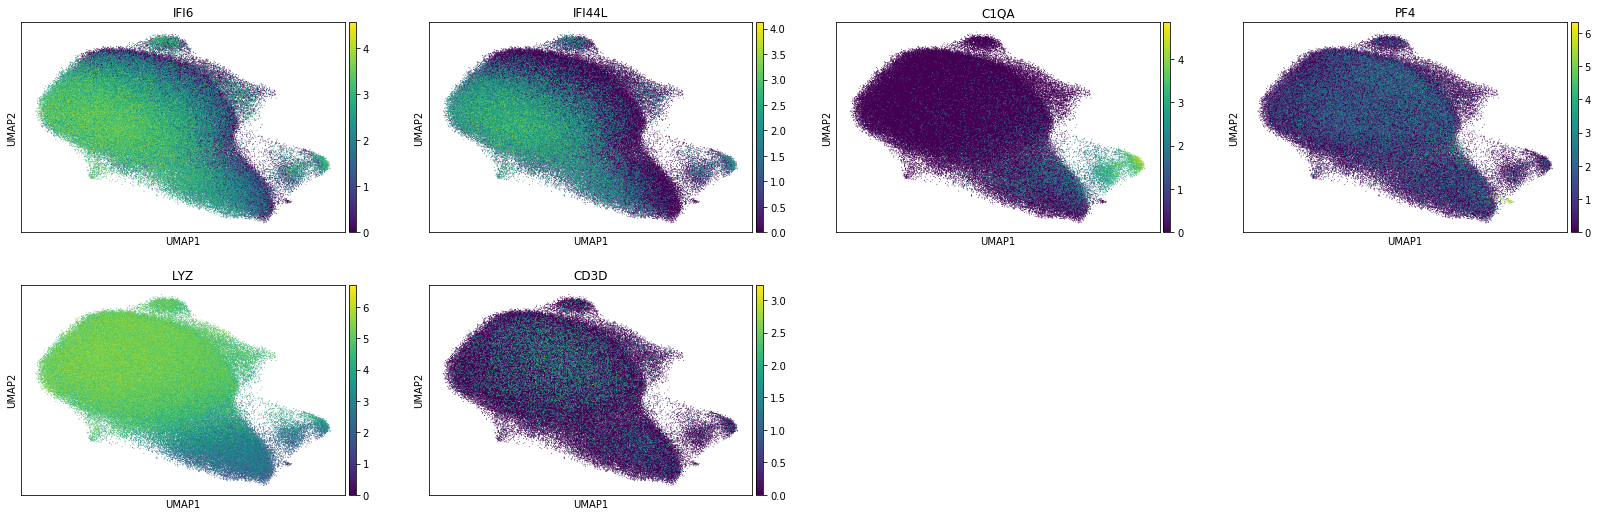

In [137]:
sc.pl.umap(adata, color=['IFI6','IFI44L','C1QA','PF4','LYZ','CD3D'], size=3)

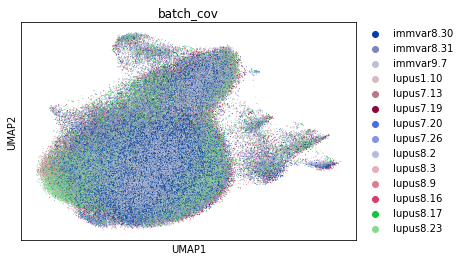

In [101]:
sc.pl.umap(adata, color=["batch_cov"], size=3)

# Now let's plot differences in cluster proportion

as a proportion of cell type
Cluster type:0
Beta=4.2131182957429685, pvalue=0.007314437940581264
Cluster type:1
Beta=-8.21108479641965, pvalue=0.00033201507102059274
Cluster type:2
Beta=1.5022916823087398, pvalue=0.23952853281077124
Cluster type:3
Beta=1.8127981397375454, pvalue=0.07733041961000628
Cluster type:4
Beta=-1.5221197783944316, pvalue=0.13168296186498474
Cluster type:5
Beta=2.392899182621893, pvalue=0.003454340293111269
Cluster type:6
Beta=-6.92616758601798, pvalue=0.0034578585334726435
Cluster type:7
Beta=1.4039919858323857, pvalue=0.32534634563680875
Cluster type:8
Beta=4.947629479609377, pvalue=5.547483323351569e-13
Cluster type:9
Beta=-0.5715338775893992, pvalue=0.0010623511915683074
Cluster type:10
Beta=0.40666692392563747, pvalue=0.010171715921102548
Cluster type:11
Beta=0.41199238877879785, pvalue=0.0012623274462787869


/Users/yimmieg/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<Figure size 1080x576 with 0 Axes>

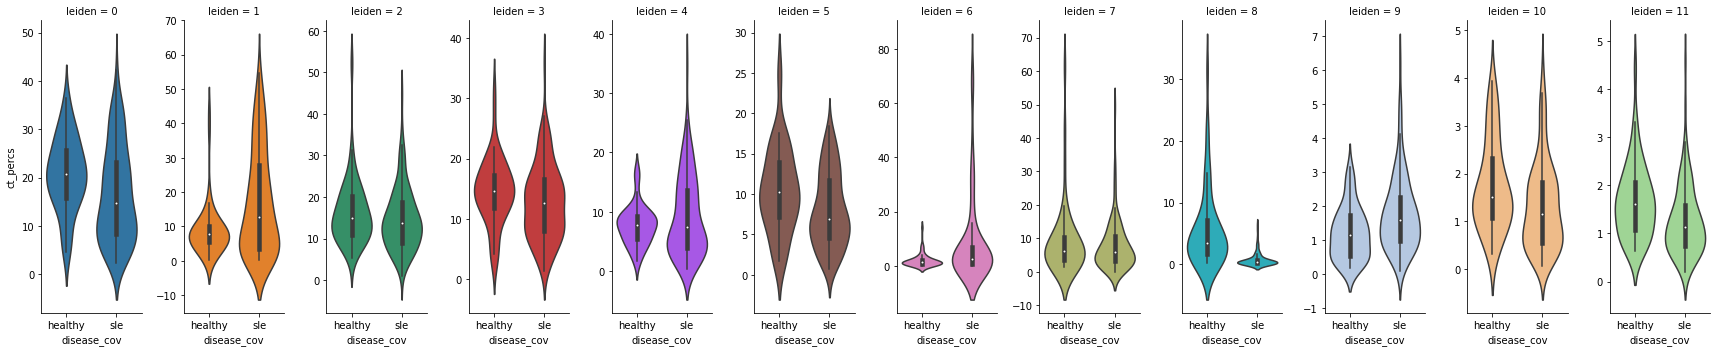

In [149]:
#get counts of cells for each cluster
ct_counts=adata.obs.groupby(['ind_cov', 'disease_cov','leiden'])['leiden'].count()
ct_percs = ct_counts/ct_counts.groupby(level=[0]).transform(sum)*100
ct_percs = ct_percs.reset_index(name='ct_percs')
ct_percs.ind_cov = ct_percs.ind_cov.apply(lambda x: x.split('_')[0])
ct_percs.ind_cov = ct_percs.ind_cov.astype("str")
ct_percs.reset_index(inplace=True)
ct_percs.leiden = ct_percs.leiden.astype("category")
ct_df=ct_percs.unstack(level=2, fill_value=0)

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.leiden.cat.categories))) :
    ct = ct_percs.leiden.cat.categories[ct_i]
    ct_perc = ct_percs.ct_percs[ct_percs.leiden==ct]
    disease = ct_percs.disease_cov[ct_percs.leiden==ct]
    disease = disease.astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    ##data = data.assign(ct_perc=ct_perc)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))

# #box plot as a proportion of cell type
# vars=[str(x) for x in list(range(n_cts))]
# ct_df['ind_cov']=ct_df.index.get_level_values('ind_cov').tolist()
# ct_df.index=ct_df['ind_cov']
# melted=pd.melt(ct_df, id_vars=['ind_cov', 'disease'], value_vars=vars)

#plot=sb.boxplot(x='disease', y='value', hue=ct_arg, data=melted).get_figure()
plt.figure(figsize=(15,8))
plot=sb.catplot(x='disease_cov', y='ct_percs', hue='leiden', data=ct_percs, kind='violin', col='leiden', dodge=False, aspect=0.4, sharex=False, sharey=False, palette=sc.pl.palettes.vega_20_scanpy)
#plt.subplots_adjust(wspace=0.03)

as a proportion of cell type
Cluster type:0
Beta=1.9176987320562173, pvalue=0.3367101019852269
Cluster type:1
Beta=0.6908303115379837, pvalue=0.7032492258934671
Cluster type:2
Beta=-9.500771659934474, pvalue=0.00023275437071199802
Cluster type:3
Beta=-3.596981799807631, pvalue=0.08539108595187002
Cluster type:4
Beta=3.127835823090394, pvalue=0.009455929677584888
Cluster type:5
Beta=-2.881148572232961, pvalue=0.021598275198766843
Cluster type:6
Beta=3.296046236519035, pvalue=1.2026830354318227e-05
Cluster type:7
Beta=1.7525384105908022, pvalue=0.002969491446677937
Cluster type:8
Beta=5.2007973613790375, pvalue=3.3284822124325704e-11
Cluster type:9
Beta=-0.57399578263972, pvalue=0.0009636230923445318
Cluster type:10
Beta=0.4022541271911304, pvalue=0.0014177631944820395


/Users/yimmieg/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<Figure size 1080x576 with 0 Axes>

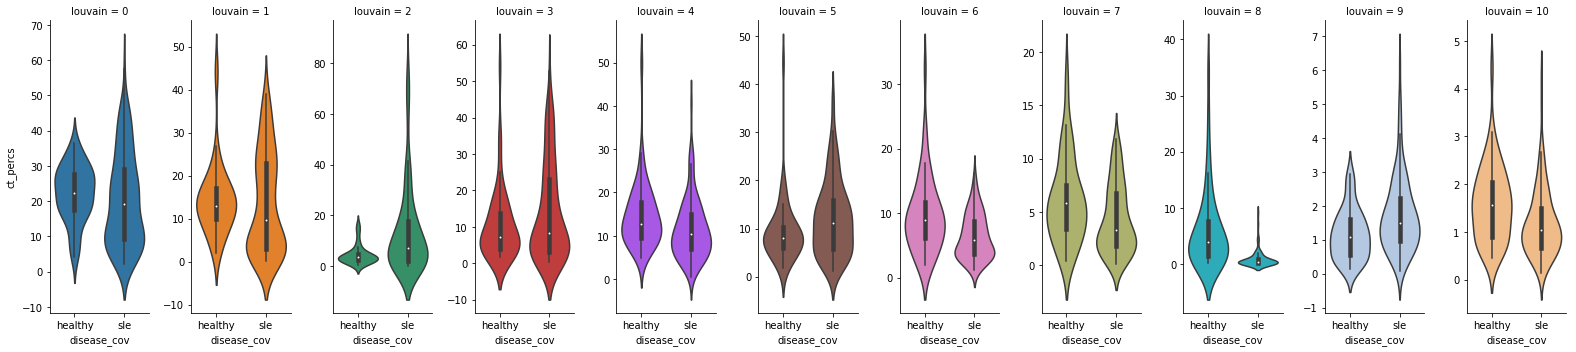

In [138]:
#get counts of cells for each cluster
ct_counts=adata.obs.groupby(['ind_cov', 'disease_cov','louvain'])['louvain'].count()
ct_percs = ct_counts/ct_counts.groupby(level=[0]).transform(sum)*100
ct_percs = ct_percs.reset_index(name='ct_percs')
ct_percs.ind_cov = ct_percs.ind_cov.apply(lambda x: x.split('_')[0])
ct_percs.ind_cov = ct_percs.ind_cov.astype("str")
ct_percs.reset_index(inplace=True)
ct_percs.louvain = ct_percs.louvain.astype("category")
ct_df=ct_percs.unstack(level=2, fill_value=0)

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))) :
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = ct_percs.ct_percs[ct_percs.louvain==ct]
    disease = ct_percs.disease_cov[ct_percs.louvain==ct]
    disease = disease.astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    ##data = data.assign(ct_perc=ct_perc)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))

# #box plot as a proportion of cell type
# vars=[str(x) for x in list(range(n_cts))]
# ct_df['ind_cov']=ct_df.index.get_level_values('ind_cov').tolist()
# ct_df.index=ct_df['ind_cov']
# melted=pd.melt(ct_df, id_vars=['ind_cov', 'disease'], value_vars=vars)

#plot=sb.boxplot(x='disease', y='value', hue=ct_arg, data=melted).get_figure()
plt.figure(figsize=(15,8))
plot=sb.catplot(x='disease_cov', y='ct_percs', hue='louvain', data=ct_percs, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=False, palette=sc.pl.palettes.vega_20_scanpy)
#plt.subplots_adjust(wspace=0.03)

# Let's also plot the absolutely abundance of each cluster

In [103]:
## Let's grab the clinical and labs data and compare to our single cell estimates
clues_clinical = pd.read_table("v2.clinical.data.txt", index_col=False)
clues_clinical.genotypeid = clues_clinical.genotypeid.apply(lambda x: x.split('_')[0])
clues_clinical.subjectid = clues_clinical.subjectid.astype("str")
joined = ct_percs.join(clues_clinical.set_index('genotypeid'), on='ind_cov')

t1_labs = pd.read_table("T1labs.csv",sep=",")
t1_labs.SubjectID = t1_labs.SubjectID.astype("str")
joined = joined.join(t1_labs.set_index('SubjectID'), on='subjectid')

### test new code
joined.AbsBaso = joined.AbsBaso/1000
joined.AbsEosino = joined.AbsEosino/1000
joined.AbsLympho = joined.AbsLympho/1000
joined.AbsNeutro = joined.AbsNeutro/1000
joined.AbsMono = joined.AbsMono/1000

joined = joined.assign(pbmc = joined.WhiteBloodCell-joined.AbsNeutro-joined.AbsEosino-joined.AbsBaso)

joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)

## now let's add in white blood cell counts for the immvar patients
immvar_pbmc = pd.read_table("immvar.pbmc.csv", index_col=False, sep=",")
immvar_pbmc.pbmc = immvar_pbmc.pbmc - (np.mean(immvar_pbmc.pbmc) - np.mean(joined.pbmc))

## this is not the most efficient code but will suffice for now
for i in list(range(12)) :
    igtb = immvar_pbmc.immvarid[i]
    joined.pbmc[joined.ind_cov==igtb] = immvar_pbmc.pbmc[i]

joined = joined.assign(estimate=joined.ct_percs/100*joined.pbmc)

joined[["ind_cov","disease_cov","louvain"]] = joined[["ind_cov","disease_cov","louvain"]].astype(str)
joined.plaquenilnow = joined.plaquenilnow.fillna(0)
joined.cellceptnow = joined.cellceptnow.fillna(0)
joined.steroralnow = joined.steroralnow.fillna(0)
joined.acrlymphopenia = joined.acrlymphopenia.fillna(0)

joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="louvain", values="estimate")
joined_pivot.reset_index(inplace=True)
joined_pivot = joined_pivot[joined_pivot.pbmc > 0]
joined_pivot.disease_cov = pd.Categorical(joined_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead.
/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


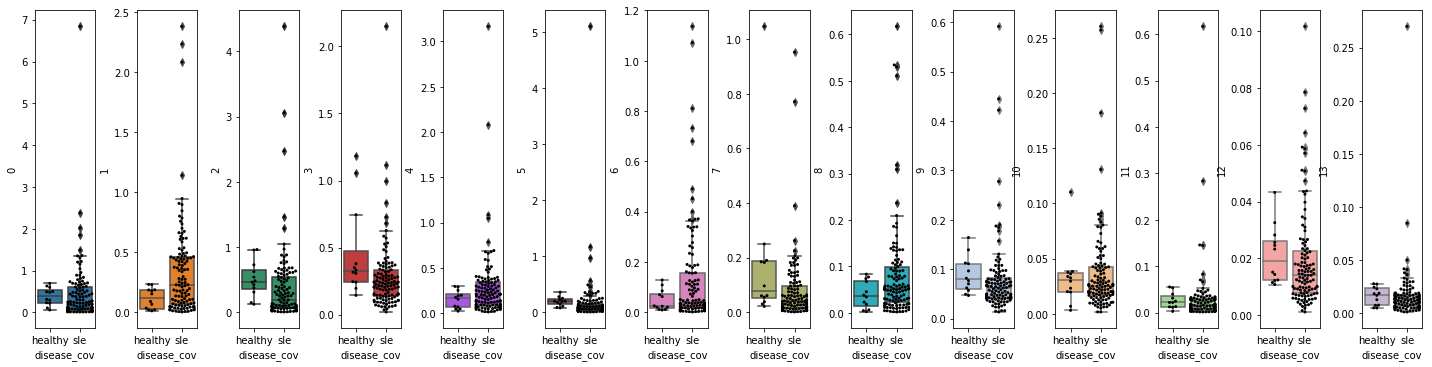

In [104]:
fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.boxplot(x="disease_cov", y=ct, data=joined_pivot, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

# Let's look at the IFN score now

In [139]:
ifn = pd.read_table("v2.ifn.sig.txt", sep=" ", index_col=False)
ifn.name = ifn.name.apply(lambda x: x.split('_')[0])
joined2 = ifn.join(joined.set_index("ind_cov"), on="name")
joined_pivot2 = joined2.pivot_table(index=['name',"disease_cov","pbmc","ifn","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="louvain", values="estimate")
joined_pivot2.reset_index(inplace=True)
joined_pivot2 = joined_pivot2[joined_pivot2.pbmc > 0]
joined_pivot2 = joined_pivot2[joined_pivot2.pbmc < 10]

/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


as a proportion of cell type
Cluster type:0
Beta=-0.04839961283636153, pvalue=9.663835229003317e-19
Cluster type:1
Beta=0.03884348072151425, pvalue=8.971096572864457e-13
Cluster type:2
Beta=-0.04645022542830866, pvalue=4.918688477771391e-20
Cluster type:3
Beta=-0.011188930723658844, pvalue=0.009306295635884792
Cluster type:4
Beta=0.02154645465010966, pvalue=3.195202721524111e-05
Cluster type:5
Beta=-0.008936252315597278, pvalue=3.086547940064821e-05
Cluster type:6
Beta=0.008817794589805321, pvalue=0.0015731542459430506
Cluster type:7
Beta=-0.0021694837168501546, pvalue=0.2533758214645041
Cluster type:8
Beta=0.0053624162901388574, pvalue=6.391504780889019e-05
Cluster type:9
Beta=-0.0017583578834154962, pvalue=0.01374090071471094
Cluster type:10
Beta=0.0003763559820802443, pvalue=0.47100017254681026


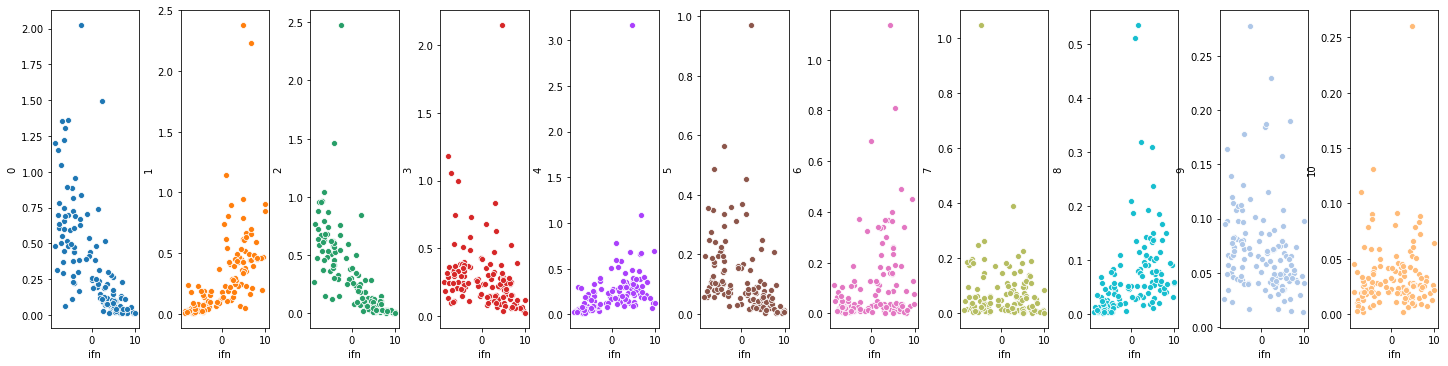

In [140]:
fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2[ct]
    ifn = joined_pivot2.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

## let's only look at disease

as a proportion of cell type
Cluster type:0
Beta=-0.05656976523488652, pvalue=3.134044593806505e-21
Cluster type:1
Beta=0.04080526421850933, pvalue=3.738817288771425e-11
Cluster type:2
Beta=-0.04951729123658684, pvalue=4.399393221433146e-19
Cluster type:3
Beta=-0.007612276584129449, pvalue=0.08711576041910545
Cluster type:4
Beta=0.02270947448495353, pvalue=0.00012144011248841516
Cluster type:5
Beta=-0.008525561029890966, pvalue=0.00038699487024434657
Cluster type:6
Beta=0.008614684361049259, pvalue=0.00685211002213697
Cluster type:7
Beta=0.000318722741992072, pvalue=0.8009381908749522
Cluster type:8
Beta=0.005408065662276085, pvalue=0.00039828419719393907
Cluster type:9
Beta=-0.0015470492207574939, pvalue=0.04968482265319932
Cluster type:10
Beta=0.00042111809347530877, pvalue=0.46749648392738996
Cluster type:11
Beta=-0.0010435375271868976, pvalue=0.013023815809865932
Cluster type:12
Beta=-0.0008517102135017448, pvalue=0.001733868195651512
Cluster type:13
Beta=-7.315484229192199e-05, pv

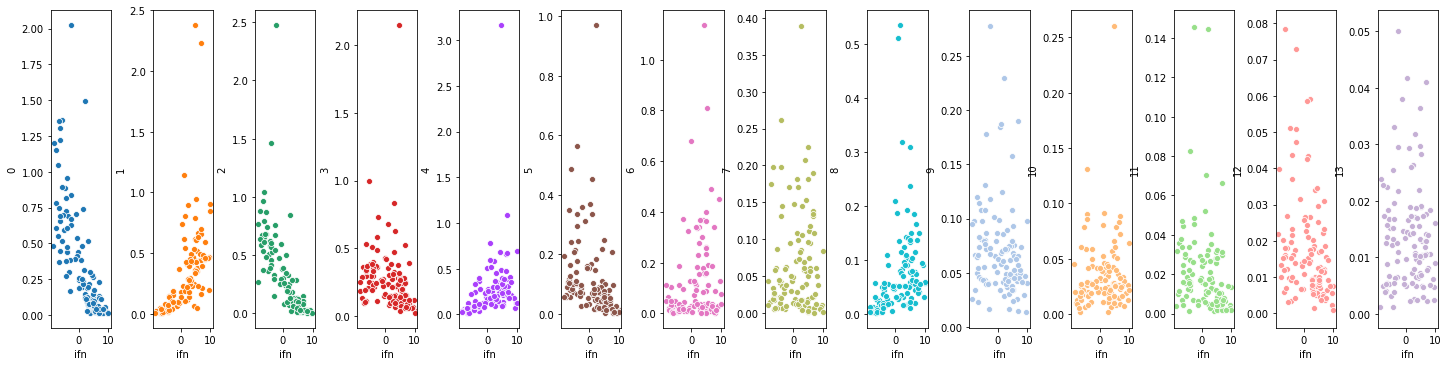

In [107]:
joined_pivot2_sle = joined_pivot2[joined_pivot2.disease_cov == "sle"]

fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2_sle[ct]
    ifn = joined_pivot2_sle.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2_sle, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

## let's only look at healthy

as a proportion of cell type
Cluster type:0
Beta=-0.07638194615256355, pvalue=0.0879664363130824
Cluster type:1
Beta=0.01659344595596092, pvalue=0.38886759745011923
Cluster type:2
Beta=-0.10180245599231866, pvalue=0.07709513958022855
Cluster type:3
Beta=-0.10517113075331243, pvalue=0.1612036387835259
Cluster type:4
Beta=0.012934622659751255, pvalue=0.5614020345172483
Cluster type:5
Beta=-0.0186190859133962, pvalue=0.30555028712743315
Cluster type:6
Beta=0.010269357215663905, pvalue=0.26693513893052223
Cluster type:7
Beta=0.04418784837237185, pvalue=0.4896800152731149
Cluster type:8
Beta=0.011875581327816284, pvalue=0.056120143528208905
Cluster type:9
Beta=-0.004432294610544606, pvalue=0.5970784149522075
Cluster type:10
Beta=-7.41762633900897e-05, pvalue=0.9904832300503078
Cluster type:11
Beta=0.0003182949085377652, pvalue=0.9364508393397042
Cluster type:12
Beta=-0.0005575635828958263, pvalue=0.8115841379100468
Cluster type:13
Beta=-0.0032050144512575118, pvalue=0.07627907278694404


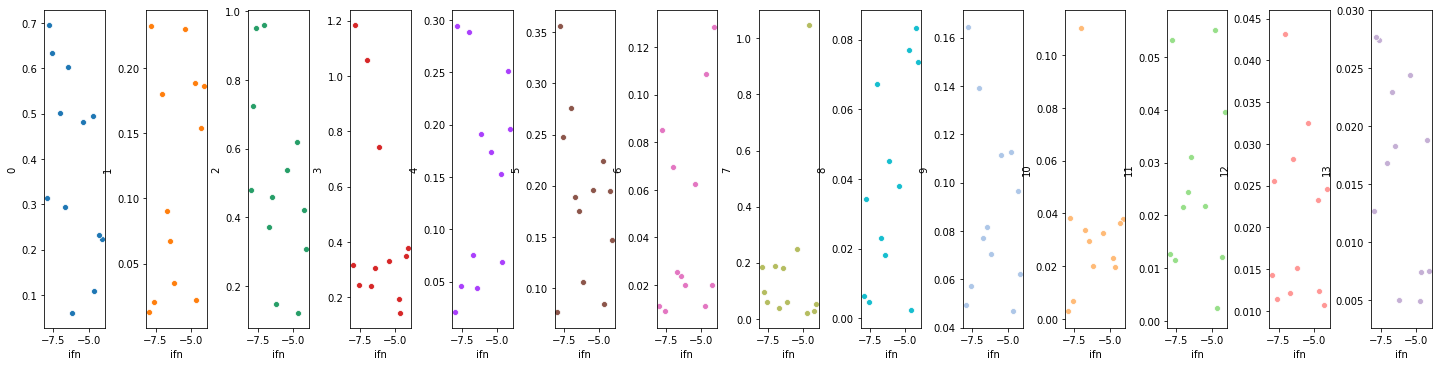

In [108]:
joined_pivot2_healthy = joined_pivot2[joined_pivot2.disease_cov == "healthy"]

fig,ax = plt.subplots(nrows=1,ncols=len(adata.obs.louvain.cat.categories), figsize=(20,5))
fig.tight_layout()

##n_cts=ct_df.shape[1]-1
print('as a proportion of cell type')
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    ct_perc = joined_pivot2_healthy[ct]
    ifn = joined_pivot2_healthy.ifn
    ifn = sm.add_constant(ifn)
    print('Cluster type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), ifn.astype(float),missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Beta='+str(effect)+', pvalue='+str(pval))
    
for ct_i in list(range(0,len(adata.obs.louvain.cat.categories))):
    ct = ct_percs.louvain.cat.categories[ct_i]
    sb.scatterplot(x="ifn", y=ct, data=joined_pivot2_healthy, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    ##sb.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])

# 6. Let's recompute the IFN score

In [109]:
diffexp_annot = pd.read_table("ifn.analysis/diffexp.annotations.txt", sep="\t", index_col=False)
diffexp_annot.cluster = diffexp_annot.cluster.astype("category")

/Users/yimmieg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [110]:
for cluster_i in diffexp_annot.cluster.cat.categories:
    print(cluster_i)
    cluster_X = adata.X[:,adata.var_names.isin(diffexp_annot.gene[diffexp_annot.cluster==cluster_i])];
    adata.obs[cluster_i] = np.sum(cluster_X, axis=1)
    

all_ifn
cM_DC_ifn
cM_ifn
dc_specific
myeloid_ifn
ncM_ifn
tc_specific
th_specific


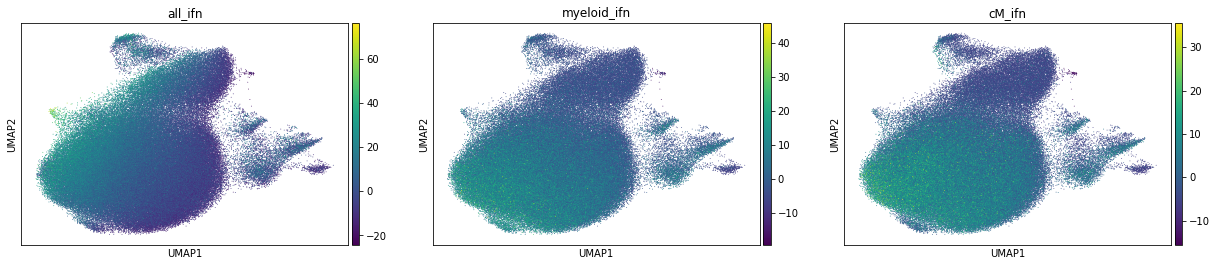

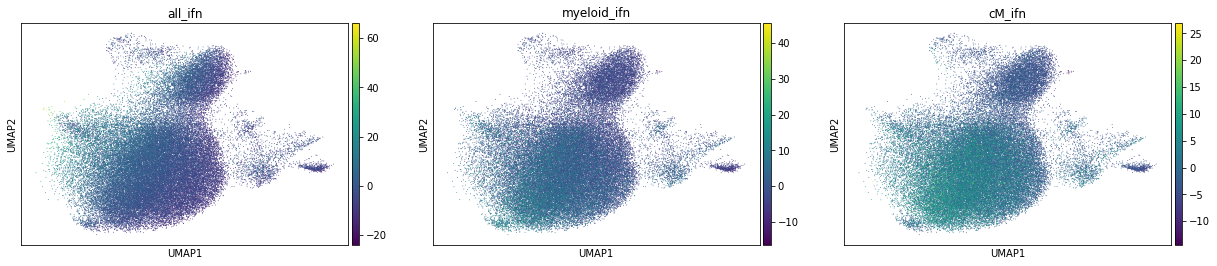

In [111]:
##fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5),sharex=True, sharey=True)
##fig.tight_layout()

sc.pl.umap(adata[adata.obs.disease_cov=="sle"], color=['all_ifn',"myeloid_ifn","cM_ifn"], palette="Greys", size=3) ##, vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)
sc.pl.umap(adata[adata.obs.disease_cov=="healthy"], color=['all_ifn',"myeloid_ifn","cM_ifn"], palette="Greys", size=3) ##,vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)



##sc.pl.umap(adata[adata.obs.disease_cov=="healthy",], color = "all_ifn", ax=ax[1])                                                      

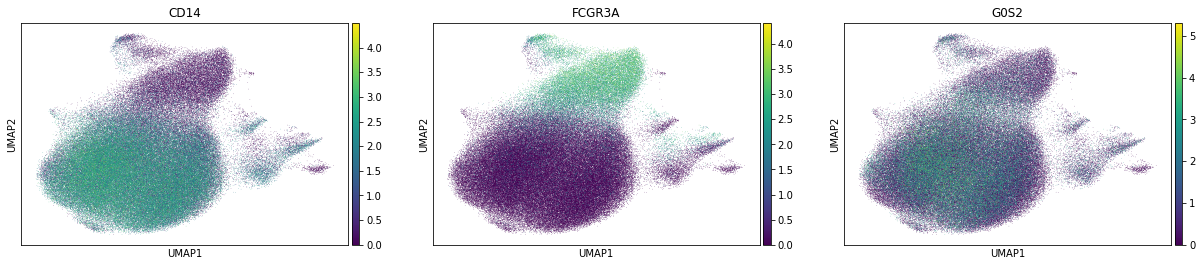

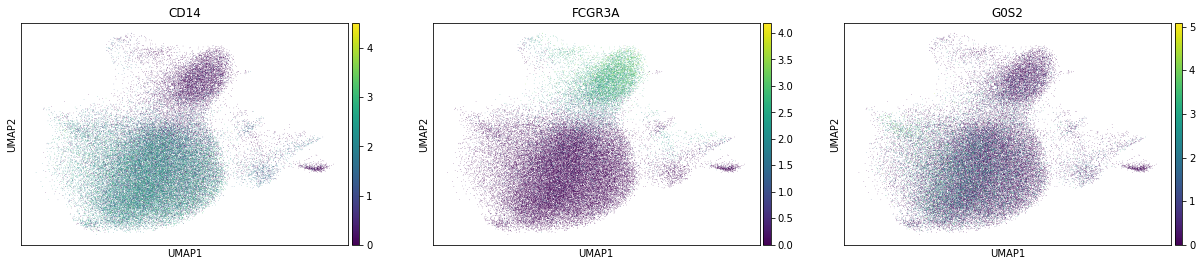

In [112]:

sc.pl.umap(adata[adata.obs.disease_cov=="sle"], color=['CD14',"FCGR3A","G0S2"], palette="Greys", size=1) ##, vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)
sc.pl.umap(adata[adata.obs.disease_cov=="healthy"], color=['CD14',"FCGR3A","G0S2"], palette="Greys", size=1) ##,vmin=min(adata.obs.all_ifn), vmax=max(adata.obs.all_ifn)*.75)



Cluster=0,Beta=0.5271859667631751, pvalue=0.25932696892188667
Cluster=1,Beta=-1.5992922204740059, pvalue=0.0005351684300020817
Cluster=2,Beta=0.3939692290866067, pvalue=0.4019189012698696
Cluster=3,Beta=-2.730083011466414, pvalue=0.008972456469912096
Cluster=4,Beta=-1.8052295470438073, pvalue=0.0036370497094527243
Cluster=5,Beta=0.5006600195469972, pvalue=0.335832491496982
Cluster=6,Beta=-0.34406691239619924, pvalue=0.5482961629719821
Cluster=7,Beta=-1.2915740959842998, pvalue=0.12761364588202354


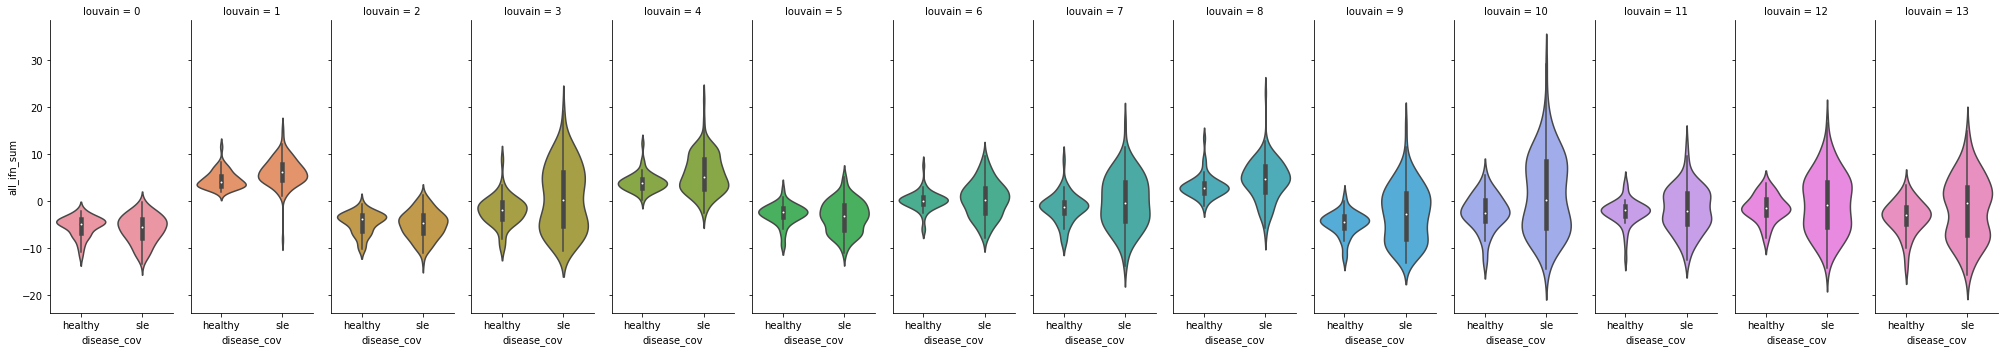

In [113]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['all_ifn'].mean()
plot_df = plot_df.reset_index(name='all_ifn_sum')

sb.catplot(x="disease_cov", y="all_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    all_ifn_sum = plot_df.all_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(all_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("all_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

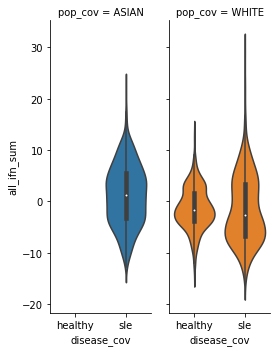

In [114]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','pop_cov','louvain'])['all_ifn'].mean()
plot_df = plot_df.reset_index(name='all_ifn_sum')

sb.catplot(x="disease_cov", y="all_ifn_sum", hue='pop_cov', data=plot_df, kind='violin', col='pop_cov', dodge=False, aspect=0.4, sharex=False, sharey=True)

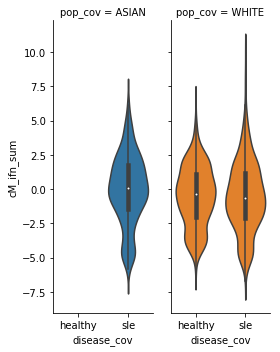

In [115]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','pop_cov','louvain'])['cM_ifn'].mean()
plot_df = plot_df.reset_index(name='cM_ifn_sum')

sb.catplot(x="disease_cov", y="cM_ifn_sum", hue='pop_cov', data=plot_df, kind='violin', col='pop_cov', dodge=False, aspect=0.4, sharex=False, sharey=True)

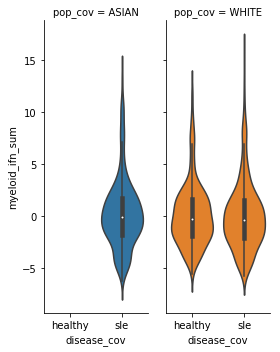

In [116]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','pop_cov','louvain'])['myeloid_ifn'].mean()
plot_df = plot_df.reset_index(name='myeloid_ifn_sum')

sb.catplot(x="disease_cov", y="myeloid_ifn_sum", hue='pop_cov', data=plot_df, kind='violin', col='pop_cov', dodge=False, aspect=0.4, sharex=False, sharey=True)

Cluster=0,Beta=-0.7434185705258811, pvalue=0.001865441975736042
Cluster=1,Beta=-0.6889539970530008, pvalue=0.015389030543335297
Cluster=2,Beta=-0.2519870384389675, pvalue=0.2695608156713651
Cluster=3,Beta=0.7676133881496774, pvalue=2.4113322056922634e-18
Cluster=4,Beta=0.012286926270031959, pvalue=0.9413220840422736
Cluster=5,Beta=0.24597581767797955, pvalue=0.2922347879147257
Cluster=6,Beta=-0.5909206443936641, pvalue=0.07013061971530722
Cluster=7,Beta=-0.558242597026894, pvalue=0.04200225124653224


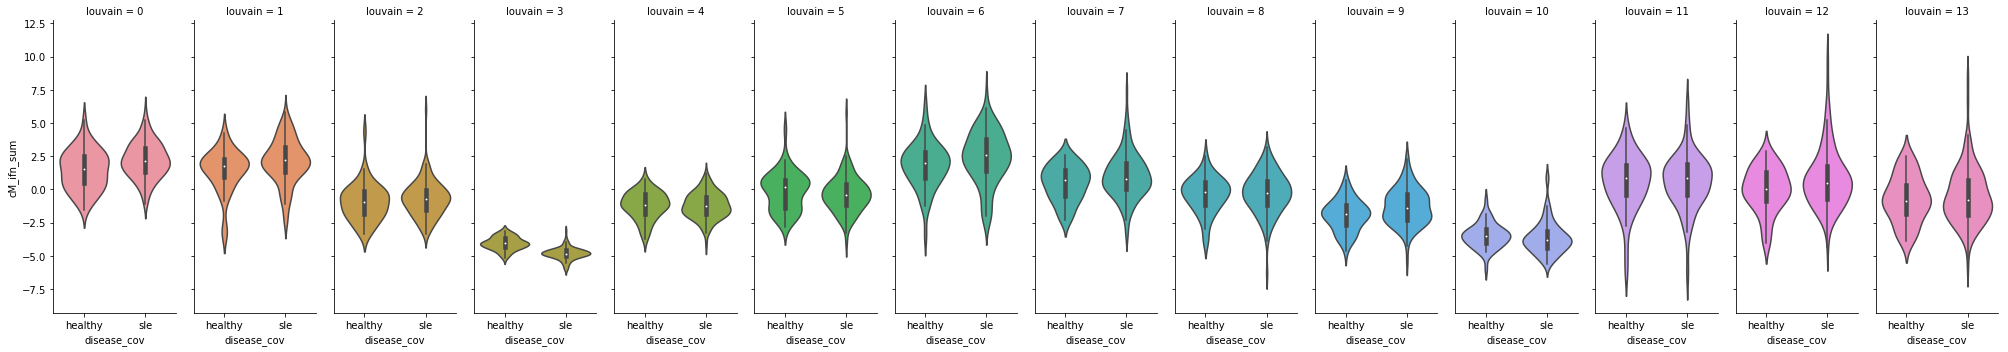

In [117]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['cM_ifn'].mean()
plot_df = plot_df.reset_index(name='cM_ifn_sum')

sb.catplot(x="disease_cov", y="cM_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    cM_ifn_sum = plot_df.cM_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(cM_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("cm_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

Cluster=0,Beta=-0.3240745994223262, pvalue=0.13338428844458072
Cluster=1,Beta=-0.3356129013869516, pvalue=0.1916431393548434
Cluster=2,Beta=-0.3434162870894712, pvalue=0.08031545089784564
Cluster=3,Beta=0.6528456130548679, pvalue=1.058658369625391e-09
Cluster=4,Beta=0.05569045296236223, pvalue=0.736788110951988
Cluster=5,Beta=0.05867337818155771, pvalue=0.7553832189406547
Cluster=6,Beta=-0.5462061018174735, pvalue=0.07844689649246922
Cluster=7,Beta=1.0799585039429684, pvalue=0.005771969651341883


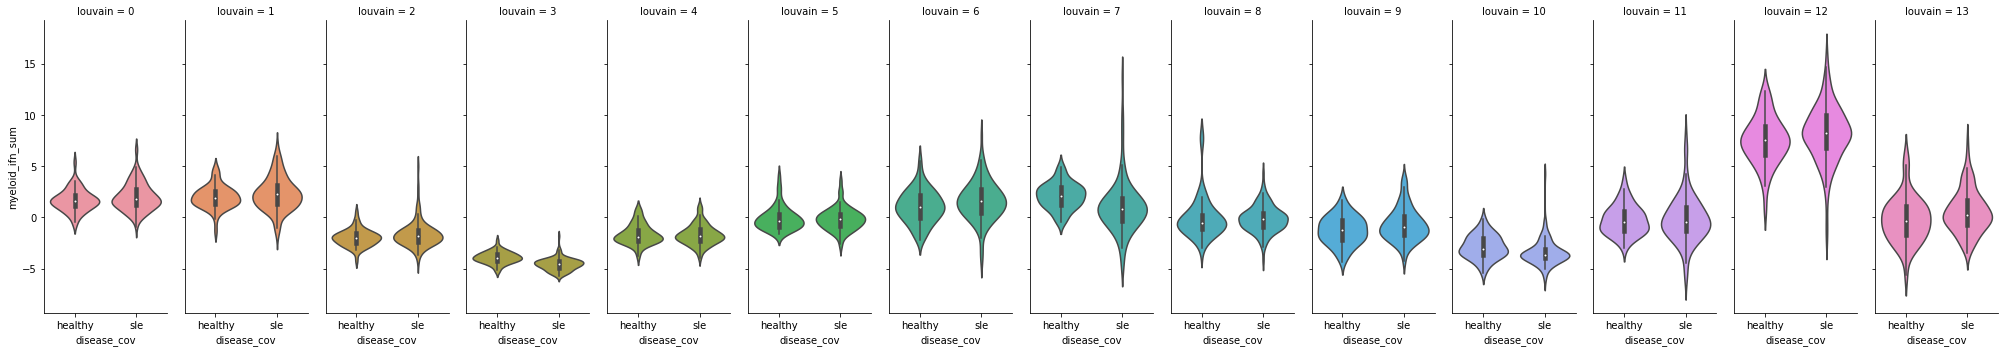

In [118]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['myeloid_ifn'].mean()
plot_df = plot_df.reset_index(name='myeloid_ifn_sum')

sb.catplot(x="disease_cov", y="myeloid_ifn_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    myeloid_ifn_sum = plot_df.myeloid_ifn_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(myeloid_ifn_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("myeloid_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))

Cluster=0,Beta=0.0, pvalue=nan
Cluster=1,Beta=0.0, pvalue=nan
Cluster=2,Beta=0.0, pvalue=nan
Cluster=3,Beta=0.0, pvalue=nan
Cluster=4,Beta=0.0, pvalue=nan
Cluster=5,Beta=0.0, pvalue=nan
Cluster=6,Beta=0.0, pvalue=nan
Cluster=7,Beta=0.0, pvalue=nan


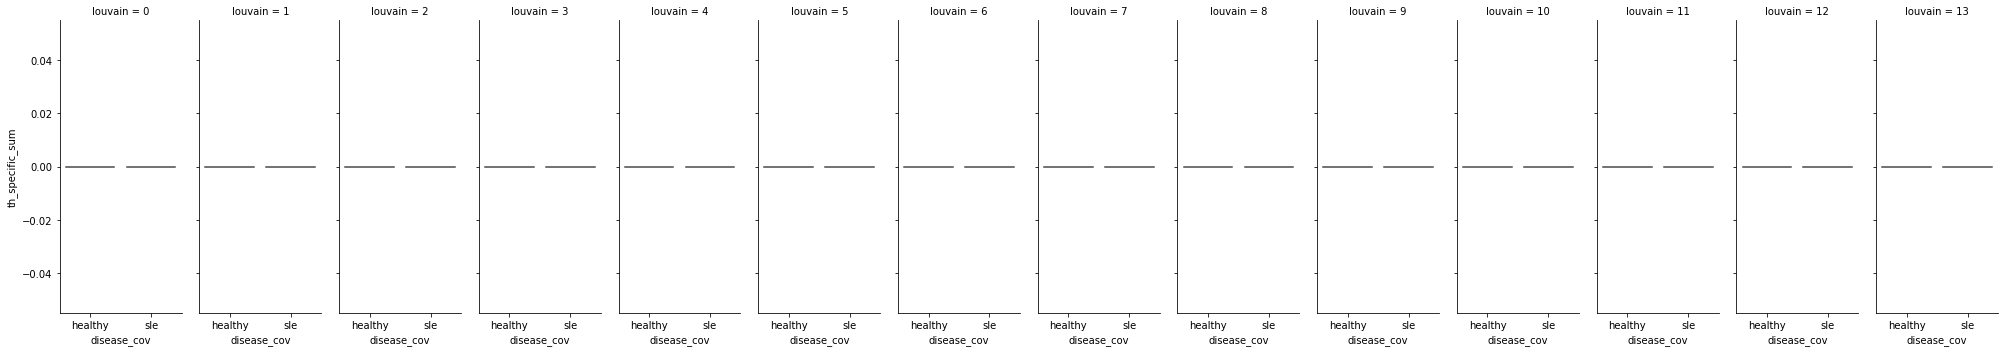

In [119]:
plot_df = adata.obs.groupby(['ind_cov','disease_cov','louvain'])['th_specific'].mean()
plot_df = plot_df.reset_index(name='th_specific_sum')

sb.catplot(x="disease_cov", y="th_specific_sum", hue='louvain', data=plot_df, kind='violin', col='louvain', dodge=False, aspect=0.4, sharex=False, sharey=True)

##n_cts=ct_df.shape[1]-1
for cluster_i in list(range(0,8)):
    cluster = plot_df.louvain.cat.categories[cluster_i]
    th_specific_sum = plot_df.th_specific_sum[plot_df.louvain == cluster]
    disease = plot_df.disease_cov[plot_df.louvain==cluster].astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.OLS(th_specific_sum.astype(float), disease.astype(float), missing='drop')
    ##est=sm.OLS("myeloid_ifn~disease_cov", data=adata.obs.input,missing='drop')
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    print('Cluster='+str(cluster)+',Beta='+str(effect)+', pvalue='+str(pval))